In this notebook we will:
- Use Albumentations to create a new augmented datasets with thousands of augmented images
- Fine tune the EfficientNetV2 model for maximum F1 score and the final deployment of the model to our website

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import albumentations as A
import pandas as pd

C:\Users\Ronan\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Hyperparameters
IMAGE_SIZE = 384
BATCH_SIZE = 8
CHANNELS= 3
ES_EPOCHS = 20 
CLASSES = 10
EPOCHS= 200
SAMPLES_AUG_IMG = 2

In [4]:
CLASS_NAMES = ["1989", "Acoustic", "Fearless", "Folkmore", "Lover", "Midnights", "Red", "Reputation", "Speak Now", "TTPD"]

In [5]:
# Train
train_directory = "C:/Users/Ronan/Documents/ML/Taylor_Swift_Projects/CNN/train"

# Val
val_directory = "C:/Users/Ronan/Documents/ML/Taylor_Swift_Projects/CNN/val"

# Test
test_directory = "C:/Users/Ronan/Documents/ML/Taylor_Swift_Projects/CNN/test"

Data augmentation pipeline using Albumentations 

In [6]:
import random

import cv2
from matplotlib import pyplot as plt

In [7]:
def visualize(image):
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(image)

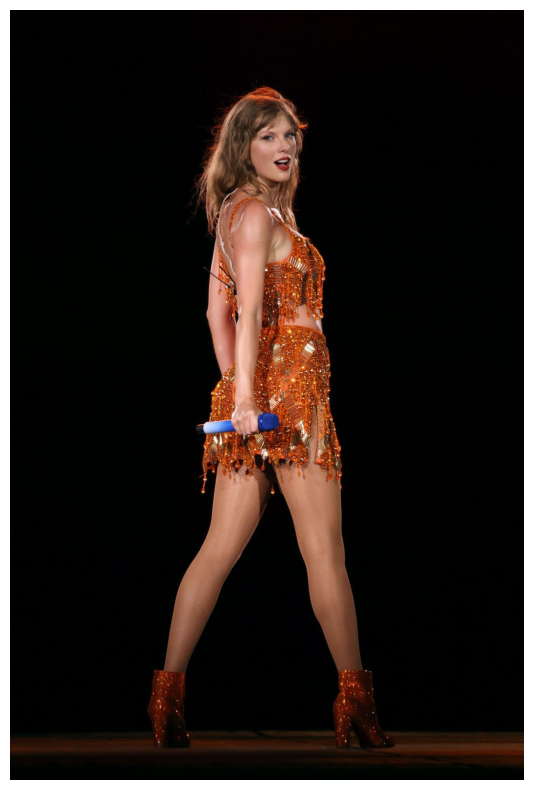

In [8]:
image = cv2.imread('Images_App_Test/1989_orange.jpeg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
visualize(image)

In [9]:
transforms = A.Compose([
            A.Rotate(limit=40),
            A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),
            A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
            A.HorizontalFlip(),
            A.ShiftScaleRotate(p=0.5),
            A.Blur(blur_limit=3),
            A.OpticalDistortion(),
            A.GridDistortion(),
        ])

In [10]:
import os
import cv2
import random
import albumentations as A

# Define paths
dataset_path = 'train'  # Replace with your dataset path
augmented_dataset_path = 'augmented_train'  # Replace with desired output path

# Define augmentation pipeline
transform = A.Compose([
    A.HorizontalFlip(p=0.5),              # Horizontal flip with 50% probability
    A.VerticalFlip(p=0.5),                # Vertical flip with 50% probability
    A.RandomRotate90(p=0.5),              # Random 90-degree rotation with 50% probability
    A.RandomBrightnessContrast(p=0.5),      # Random brightness/contrast adjustments
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),  # Random shift, scale, and rotation
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),  # Random hue, saturation, and value adjustments
    A.GaussianBlur(blur_limit=(3, 7), p=0.5),  # Gaussian blur with random kernel size
], p=1.0)  # Apply the entire pipeline with probability 1.0

# Function to augment images in a directory
def augment_images(source_dir, dest_dir, num_augmentations=SAMPLES_AUG_IMG):
    """
    Augments images in a source directory and saves them to a destination directory.

    Args:
        source_dir (str): Path to the directory containing the original images.
        dest_dir (str): Path to the directory where augmented images will be saved.
        num_augmentations (int): Number of augmentations to generate per image.
    """
    for filename in os.listdir(source_dir):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(source_dir, filename)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            for i in range(num_augmentations):
                augmented_image = transform(image=image)['image']
                augmented_filename = f"{os.path.splitext(filename)[0]}_aug_{i}.jpg"
                augmented_path = os.path.join(dest_dir, augmented_filename)
                cv2.imwrite(augmented_path, cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR))

# Create the augmented dataset directory structure
if not os.path.exists(augmented_dataset_path):
    os.makedirs(augmented_dataset_path)

# Iterate through classes and augment images
for class_name in os.listdir(dataset_path):
    class_source_dir = os.path.join(dataset_path, class_name)
    class_dest_dir = os.path.join(augmented_dataset_path, class_name)
    if not os.path.exists(class_dest_dir):
        os.makedirs(class_dest_dir)
    augment_images(class_source_dir, class_dest_dir)

print("Data augmentation complete!")

Data augmentation complete!


In [11]:
# Directory with the images
test_dir = "C:/Users/Ronan/Documents/ML/Taylor_Swift_Projects/CNN/test"
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    seed=42,
    label_mode='int',
    validation_split=None,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
)

Found 293 files belonging to 10 classes.


In [12]:
# Directory with the images
train_dir = "C:/Users/Ronan/Documents/ML/Taylor_Swift_Projects/CNN/augmented_train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    seed = 42,
    label_mode='int',
    validation_split=None,
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 6850 files belonging to 10 classes.


In [13]:
# Directory with the images
val_dir = "C:/Users/Ronan/Documents/ML/Taylor_Swift_Projects/CNN/val"
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    seed = 42,
    label_mode='int',
    validation_split=None,
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 302 files belonging to 10 classes.


In [14]:
print(f"""
    ----------------------------------
    Dataset split:
        - train split: {len(train_ds)}
        - val split: {len(val_ds)}
        - test split: {len(test_ds)}
    ----------------------------------
    """
)


    ----------------------------------
    Dataset split:
        - train split: 857
        - val split: 38
        - test split: 37
    ----------------------------------
    


In [15]:
#Caching the dataset

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
import os
import seaborn as sns
main_folder = 'augmented_train'

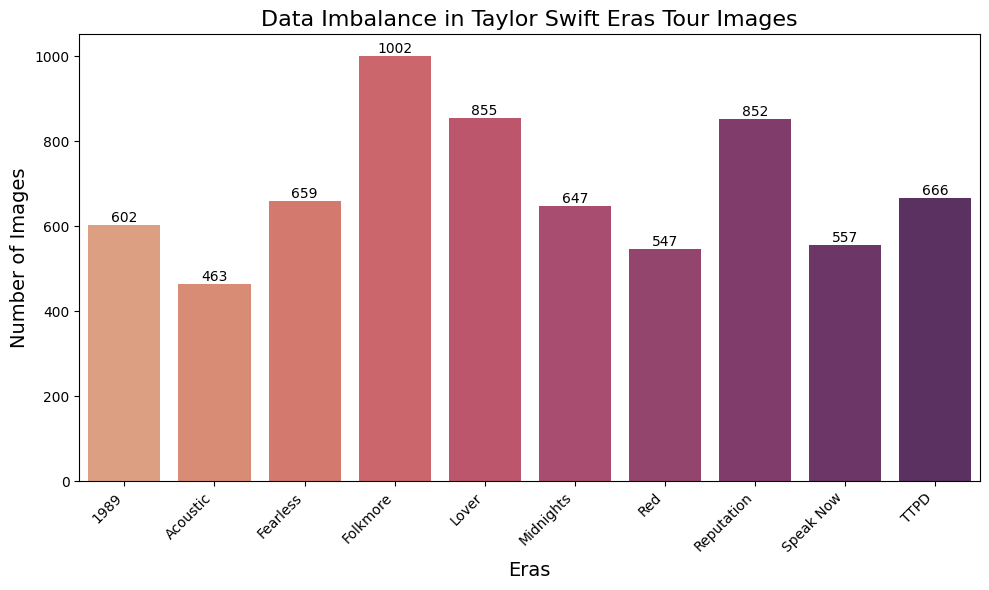

In [17]:
era_counts = {}

# Iterate through each subfolder (era)
for era_folder in os.listdir(main_folder):
    era_path = os.path.join(main_folder, era_folder)
    if os.path.isdir(era_path):
        # Count the number of images in the era folder
        era_counts[era_folder] = len([filename for filename in os.listdir(era_path) if filename.lower().endswith(('.jpg', '.jpeg', '.png'))])

# Create a pandas DataFrame from the era_counts dictionary
import pandas as pd
df = pd.DataFrame({'Era': era_counts.keys(), 'Image Count': era_counts.values()})

# Create the bar plot using seaborn
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
ax = sns.barplot(x='Era', y='Image Count', data=df, palette='flare')  # Choose a color palette you like
for bar in range(len(ax.containers)):
    ax.bar_label(ax.containers[bar])
# Customize the plot
plt.title('Data Imbalance in Taylor Swift Eras Tour Images', fontsize=16)
plt.xlabel('Eras', fontsize=14)
plt.ylabel('Number of Images', fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout for better spacing

# Display the plot
plt.show()

In [18]:
def get_weight_inverse_num_samples(num_of_classes, samples_per_classes, coeff=1):
    """
    Get the inverse number of samples for each class.
    Args:
        num_of_classes (int): Number of classes in the dataset.
        samples_per_classes (list): List of number of samples per class.
        power (int, optional): Power of the inverse number of samples. Defaults to 1.
    Returns:
        list: List of inverse number of samples for each class.
    """

    inverse_num_samples = []
    total_samples = sum(samples_per_classes)

    for i in range(num_of_classes):
        inverse_num_samples.append((total_samples / (num_of_classes * samples_per_classes[i])) * coeff)

    return inverse_num_samples

num_of_classes = 10
samples_per_classes = [era_counts['1989'], era_counts['Acoustic'], era_counts['Fearless'], era_counts['Folkmore'], era_counts['Lover'], era_counts['Midnights'], era_counts['Red'], era_counts['Reputation'], era_counts['Speak Now'], era_counts['TTPD']] 

weighted_classes = get_weight_inverse_num_samples(num_of_classes, samples_per_classes)


In [19]:
class_indexes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [20]:
weights = dict(zip(class_indexes, weighted_classes))

In [21]:
weights

{1: 1.1378737541528239,
 2: 1.4794816414686824,
 3: 1.039453717754173,
 4: 0.6836327345309381,
 5: 0.8011695906432749,
 6: 1.0587326120556415,
 7: 1.2522851919561244,
 8: 0.8039906103286385,
 9: 1.229802513464991,
 10: 1.0285285285285286}

In [22]:
conv_base = tf.keras.applications.EfficientNetV2S(
    include_top=False,
    weights="imagenet",
    classifier_activation="softmax",
)

In [23]:
for layer in conv_base.layers[:-8]:
    layer.trainable = False

In [24]:
conv_base.summary()

Model: "efficientnetv2-s"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, None,      │          0 │ input_layer[0][0] │
│ (Rescaling)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, None,      │        648 │ rescaling[0][0]   │
│                     │ None, 24)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, None,      │         96 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ None, 24)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, None,      │          0 │ stem_bn[0][0]     │
│ (Activation)        │ None, 24)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, None,      │      5,184 │ stem_activation[… │
│ (Conv2D)            │ None, 24)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, None,      │         96 │ block1a_project_… │
│ (BatchNormalizatio… │ None, 24)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, None,      │          0 │ block1a_project_… │
│ (Activation)        │ None, 24)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_add (Add)   │ (None, None,      │          0 │ block1a_project_… │
│                     │ None, 24)         │            │ stem_activation[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, None,      │      5,184 │ block1a_add[0][0] │
│ (Conv2D)            │ None, 24)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, None,      │         96 │ block1b_project_… │
│ (BatchNormalizatio… │ None, 24)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, None,      │          0 │ block1b_project_… │
│ (Activation)        │ None, 24)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, None,      │          0 │ block1b_project_… │
│ (Dropout)           │ None, 24)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, None,      │          0 │ block1b_drop[0][… │
│                     │ None, 24)         │            │ block1a_add[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, None,      │     20,736 │ block1b_add[0][0] │
│ (Conv2D)            │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, None,      │        384 │ block2a_expand_c… │
│ (BatchNormalizatio… │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, None,      │          0 │ block2a_expand_b

 Total params: 20,331,360 (77.56 MB)

 Trainable params: 723,968 (2.76 MB)

 Non-trainable params: 19,607,392 (74.80 MB)

In [25]:
from tensorflow.keras.regularizers import l2

In [26]:
inputs = tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

x = tf.keras.applications.efficientnet_v2.preprocess_input(inputs)

# The output of the base model is taken as the input for the new model
x = conv_base(x)
# This layer averages the spatial dimensions (height and width) of the output from the previous layer
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# Add a Dense layer with 512 units and 'relu' activation function to the model
x = tf.keras.layers.Dense(512, activation="relu")(x)
# This layer randomly sets a fraction of input units to 0 at each update during training time, which helps prevent overfitting
x = tf.keras.layers.Dropout(0.5)(x)
# This layer will output the probabilities for the 10 classes
outputs = tf.keras.layers.Dense(CLASSES, activation="softmax", kernel_regularizer=l2(0.001))(x)

#outputs = tf.keras.layers.Dense(CLASSES, activation="softmax")(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [27]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [28]:
from tensorflow.keras import callbacks

In [29]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [30]:
filepath="saved_models/all_VGG16_models/best_model_weighted_RESNET50_getty_aug.keras"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
lr_plateau = callbacks.ReduceLROnPlateau(factor=0.8, monitor="val_accuracy", patience=5, verbose=1)
es = EarlyStopping(monitor='val_accuracy', patience=ES_EPOCHS)
callbacks_list = [checkpoint, es, lr_plateau]

In [31]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
    callbacks=callbacks_list,
    class_weight=weights
)

Epoch 1/200
857/857 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - accuracy: 0.1543 - loss: 2.3739
Epoch 1: val_accuracy improved from -inf to 0.49338, saving model to saved_models/all_VGG16_models/best_model_weighted_RESNET50_getty_aug.keras
857/857 ━━━━━━━━━━━━━━━━━━━━ 432s 483ms/step - accuracy: 0.1543 - loss: 2.3738 - val_accuracy: 0.4934 - val_loss: 1.8968 - learning_rate: 1.0000e-05
Epoch 2/200
857/857 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.3741 - loss: 2.0109
Epoch 2: val_accuracy improved from 0.49338 to 0.60596, saving model to saved_models/all_VGG16_models/best_model_weighted_RESNET50_getty_aug.keras
857/857 ━━━━━━━━━━━━━━━━━━━━ 401s 468ms/step - accuracy: 0.3741 - loss: 2.0108 - val_accuracy: 0.6060 - val_loss: 1.5080 - learning_rate: 1.0000e-05
Epoch 3/200
857/857 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.4661 - loss: 1.7332
Epoch 3: val_accuracy improved from 0.60596 to 0.68212, saving model to saved_models/all_VGG16_models/best_model_weighted_RESNET50_getty_aug.ker

In [32]:
filepath = "saved_models/all_VGG16_models/best_model_weighted_RESNET50_getty_aug.keras"
best_model = tf.keras.models.load_model(filepath)

In [33]:
scores = best_model.predict(test_ds)

37/37 ━━━━━━━━━━━━━━━━━━━━ 23s 561ms/step


In [34]:
def create_list_y(dataset, model):
  y_true = []
  y_pred = []

  for x, y in dataset:
    y_true.append(y)
    y_pred.append(tf.argmax(model.predict(x),axis = 1))
    
  y_pred = tf.concat(y_pred, axis=0)
  y_true = tf.concat(y_true, axis=0)

  return y_pred, y_true

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

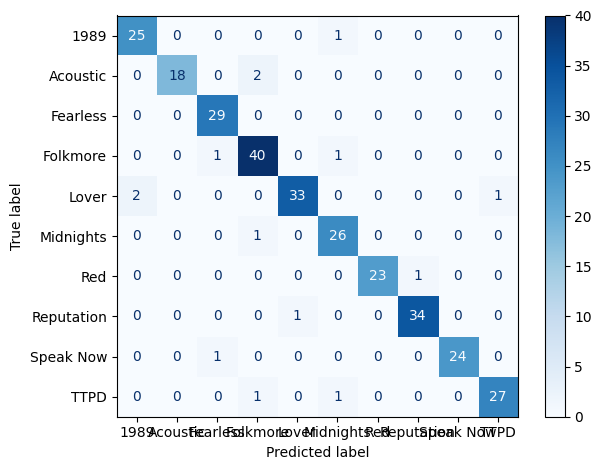

In [35]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

y_pred, y_true = create_list_y(test_ds, best_model)

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_NAMES)

disp.plot(cmap=plt.cm.Blues)
plt.tight_layout()
plt.show()

In [36]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

              precision    recall  f1-score   support

        1989       0.93      0.96      0.94        26
    Acoustic       1.00      0.90      0.95        20
    Fearless       0.94      1.00      0.97        29
    Folkmore       0.91      0.95      0.93        42
       Lover       0.97      0.92      0.94        36
   Midnights       0.90      0.96      0.93        27
         Red       1.00      0.96      0.98        24
  Reputation       0.97      0.97      0.97        35
   Speak Now       1.00      0.96      0.98        25
        TTPD       0.96      0.93      0.95        29

    accuracy                           0.95       293
   macro avg       0.96      0.95      0.95       293
weighted avg       0.95      0.95      0.95       293

